In [ ]:
!pip install PyDrive

In [ ]:
!pip install shap

In [ ]:
!pip install keras

In [ ]:
!pip install sklearn

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import seaborn as sns
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier
import math
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
import geopy.distance

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
downloaded = drive.CreateFile({'id':"17TlCXfs4WKyo8nshLrTGoVTLOvP6CIyr"})   # replace the id with id of file you want to access
downloaded.GetContentFile('fraudTrain.csv')

In [ ]:
#3. Read file as panda dataframe
import pandas as pd
data = pd.read_csv('fraudTrain.csv') 

# Exploration of Data

In [ ]:
data.shape

(1296675, 23)

In [ ]:
data.isna().sum()

In [ ]:
fraud = data.loc[data['is_fraud']==1]
non_fraud = data.loc[data['is_fraud']==0]

In [ ]:
fraud.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,7506.00,7506.00,7506.00,7506.00,7506.00,7506.00,7506.00,7506.00,7506.00,7506.00,7506.00
mean,624949.72,400357683719606400.00,531.32,48038.71,38.66,-89.92,97276.76,1348389120.97,38.65,-89.92,1.00
std,401056.01,1276871477748873216.00,390.56,27265.56,5.17,14.28,326581.47,13830201.29,5.22,14.30,0.00
min,2449.00,60416207185.00,1.06,1330.00,20.03,-165.67,23.00,1325466397.00,19.43,-166.55,1.00
25%,239856.50,180042946491150.00,245.66,24927.00,35.06,-96.70,746.50,1335743544.75,35.11,-96.67,1.00
50%,638162.00,3528040995648998.00,396.50,46290.00,39.43,-86.69,2623.00,1348872455.50,39.43,-86.81,1.00
75%,984921.50,4651007077623147.00,900.88,71107.00,42.07,-79.94,21437.00,1360021288.00,41.99,-79.91,1.00
max,1295733.00,4992346398065154048.00,1376.04,99783.00,66.69,-68.56,2906700.00,1371787186.00,67.51,-67.57,1.00


In [ ]:
non_fraud.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1289169.00,1289169.00,1289169.00,1289169.00,1289169.00,1289169.00,1289169.00,1289169.00,1289169.00,1289169.00,1289169.00
mean,648473.17,417290057695786368.00,67.67,48805.11,38.54,-90.23,88775.23,1349248612.02,38.54,-90.23,0.00
std,374152.59,1308989951701786880.00,154.01,26890.99,5.08,13.76,301806.55,12835136.65,5.11,13.77,0.00
min,0.00,60416207185.00,1.00,1257.00,20.03,-165.67,23.00,1325376018.00,19.03,-166.67,0.00
25%,324610.00,180042946491150.00,9.61,26237.00,34.62,-96.80,743.00,1338759022.00,34.73,-96.90,0.00
50%,648411.00,3521417320836166.00,47.28,48174.00,39.35,-87.48,2456.00,1349254228.00,39.37,-87.44,0.00
75%,972399.00,4642255475285942.00,82.54,72042.00,41.94,-80.16,20328.00,1359378150.00,41.96,-80.24,0.00
max,1296674.00,4992346398065154048.00,28948.90,99783.00,65.69,-67.95,2906700.00,1371816817.00,66.68,-66.95,0.00


In [ ]:
fraud['trans_date_trans_time'] = pd.to_datetime(fraud['trans_date_trans_time'])
fraud.dtypes['trans_date_trans_time']

fraud['transaction_hour'] = fraud['trans_date_trans_time'].dt.hour

data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data.dtypes['trans_date_trans_time']

data['transaction_hour'] = data['trans_date_trans_time'].dt.hour

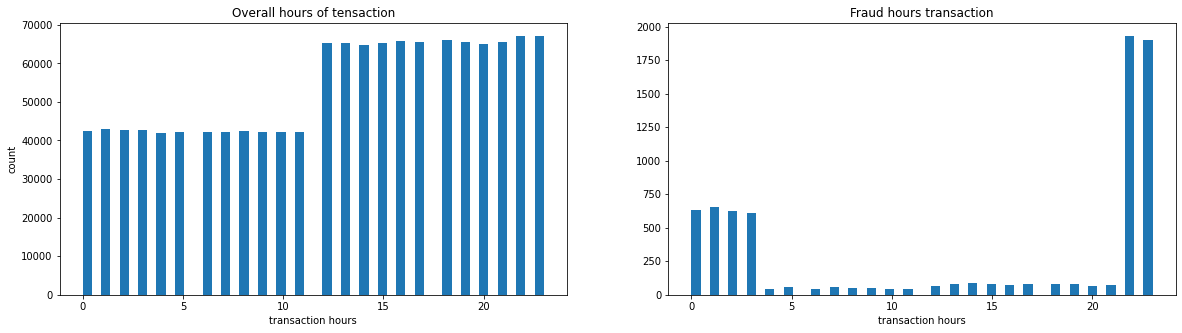

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data['transaction_hour'], bins=50)
ax[1].hist(fraud['transaction_hour'], bins=50)

ax[0].set_title('Overall hours of tensaction')
ax[1].set_title('Fraud hours transaction')

ax[0].set_xlabel('transaction hours')
ax[0].set_ylabel('count')

ax[1].set_xlabel('transaction hours')

plt.show()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data['distance'], bins=100)
ax[1].hist(fraud['distance'], bins=100)

ax[0].set_title('distance distribution for overall trasaction')
ax[1].set_title('distance distribution for fradulent trasaction')

ax[0].set_xlabel('distance between customer and merchant')
ax[0].set_ylabel('count')

ax[1].set_xlabel('distance between customer and merchant')

plt.show()

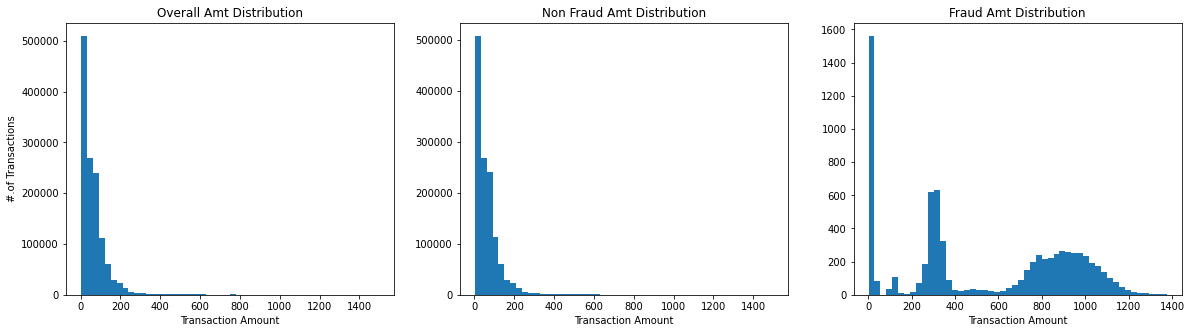

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].hist(data[data['amt']<=1500]['amt'], bins=50)
ax[1].hist(data[(data['is_fraud']==0) & (data['amt']<=1500)]['amt'], bins=50)
ax[2].hist(data[(data['is_fraud']==1) & (data['amt']<=1500)]['amt'], bins=50)

ax[0].set_title('Overall Amt Distribution')
ax[1].set_title('Non Fraud Amt Distribution')
ax[2].set_title('Fraud Amt Distribution')

ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('#.of Transactions')

ax[1].set_xlabel('Transaction Amount')
ax[2].set_xlabel('Transaction Amount')
plt.show()

# Feature Engineering 

In [ ]:
# calculating % of fraud happened in each hour
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data.dtypes['trans_date_trans_time']

data['transaction_hour'] = data['trans_date_trans_time'].dt.hour

t = data.groupby('transaction_hour').count()
t = t['trans_num']
t = pd.DataFrame(t)
t = t.rename(columns={'trans_num':'Actual_transaction'})

fraud_t = data.loc[data['is_fraud']==1]
tf = fraud_t.groupby('transaction_hour').count()
tf = tf['trans_num']

time = pd.concat([t, tf], axis=1)
time[['Actual_transaction','trans_num']]

time = time.rename(columns={'trans_num':'Fradulent_transaction'})

time['Fradulent_transaction'] = time['Fradulent_transaction'].fillna(0)

time['fraud_rate%_by_hour'] = (time['Fradulent_transaction'] / time['Actual_transaction']) * 100

time = time.sort_values(['fraud_rate%_by_hour'], ascending=False)
fr_time = pd.DataFrame(time['fraud_rate%_by_hour'])

act_time = data['transaction_hour']
act_time = pd.DataFrame(act_time)

new_time = pd.merge(act_time, fr_time, how='left', on='transaction_hour')
new_time

,transaction_hour,fraud_rate%_by_hour
0,0,1.494047
1,0,1.494047
2,0,1.494047
3,0,1.494047
4,0,1.494047
...,...,...
1296670,12,0.102671
1296671,12,0.102671
1296672,12,0.102671
1296673,12,0.102671


In [ ]:
data['transaction_hour'] = new_time['fraud_rate%_by_hour']

In [ ]:
# calculating % of fraud happened profession wise - assigning high risk and low risk to the profession accordingly
t_categ_anal = data.groupby('category')[['trans_num']].count().reset_index()
t_categ_anal.rename({'trans_num':'total_count_of_trasactions'}, axis=1)

f_categ_anal = data[data['is_fraud']==1].groupby('category')[['trans_num']].count().reset_index()
f_categ_anal.rename({'trans_num':'count_of_fraud_trasactions'}, axis=1)

categ_anal = pd.merge(t_categ_anal, f_categ_anal, how='left', on='category')
categ_anal['fraud_perc'] = (categ_anal['trans_num_y'] / categ_anal['trans_num_x']) * 100
categ_anal = categ_anal.sort_values(['fraud_perc'], ascending=False)

t_job_anal = data.groupby('job')[['trans_num']].count().reset_index()
t_job_anal = t_job_anal.sort_values(['trans_num'], ascending=False)

f_job_anal = data[data['is_fraud']==1].groupby('job')[['trans_num']].count().reset_index()
f_job_anal = f_job_anal.sort_values(['trans_num'], ascending=False)

job_anal = pd.merge(t_job_anal, f_job_anal, how='inner', on='job')
job_anal['fraud_perc'] = (job_anal['trans_num_y'] / job_anal['trans_num_x']) * 100
job_anal = job_anal.sort_values(['fraud_perc'], ascending=False)
high_fraud = job_anal[job_anal['fraud_perc'] > 90]
#high_fraud = pd.DataFrame(high_fraud['job'])
high_fraud_job = high_fraud['job'].tolist()

new_job = []

for job in data['job']:
  for fraud_job in high_fraud_job:
    if fraud_job == job:
      new_job.append('high risk')
      break
  else:
    new_job.append('low risk')

data['job'] = new_job

In [ ]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(data[['job']]).toarray())
enc_df
data = data.join(enc_df)

In [ ]:
data.rename({0:'low risk job', 1:'high risk job'}, axis=1, inplace=True)

In [ ]:
#calculating % fraud zip code wise
z = data.groupby('zip').count()
z = z['city']
z = pd.DataFrame(z)
z = z.rename(columns={'city':'Actual_transaction'})

fraud = data.loc[data['is_fraud']==1]
zf = fraud.groupby('zip').count()
zf = zf['city']

zip = pd.concat([z, zf], axis=1)
zip[['Actual_transaction','city']]

zip = zip.rename(columns={'city':'Fradulent_transaction'})

zip['Fradulent_transaction'] = zip['Fradulent_transaction'].fillna(0)

zip['fraud_rate%'] = (zip['Fradulent_transaction'] / zip['Actual_transaction']) * 100

zip = zip.sort_values(['fraud_rate%'], ascending=False)
fr_zip = pd.DataFrame(zip['fraud_rate%'])

# Replacing Zip codes with fraud rates
act_zip = data['zip']
act_zip = pd.DataFrame(act_zip)

new_zip = pd.merge(act_zip, fr_zip, how='left', on='zip')

data['zip'] = new_zip['fraud_rate%']
data['zip']

In [ ]:
# normalising amount column
data['amt'] = np.log(data['amt'])
data['amt'].skew()

In [ ]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(data[['gender']]).toarray())
enc_df
data = data.join(enc_df)

In [ ]:
data.rename({0:'female', 1:'male'}, axis=1, inplace=True)

In [ ]:
data['category'].replace({'misc_net':1, 'grocery_pos':2, 'entertainment':3, 'gas_transport':4, 'misc_pos':5, 'grocery_net':6, 'shopping_net':7, 'shopping_pos':8, 'food_dining':9, 'personal_care':10, 'health_fitness':11, 'travel':12, 'kids_pets':13, 'home':14})

In [ ]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(data[['category']]).toarray())
enc_df
data = data.join(enc_df)

In [ ]:
data.rename({0:'misc_net', 1:'grocery_pos', 2:'entertainment', 3:'gas_transport', 4:'misc_pos', 5:'grocery_net', 6:'shopping_net', 7:'shopping_pos', 8:'food_dining', 9:'personal_care', 10:'health_fitness', 11:'travel', 12:'kids_pets', 13:'home'}, axis=1, inplace=True)

In [ ]:
data['day_of_week'] = data['trans_date_trans_time'].dt.day_name()
data['day_of_week']

In [ ]:
label_encoder = preprocessing.LabelEncoder()
data['day_of_week'] = label_encoder.fit_transform(data['day_of_week'])
data['day_of_week'].unique()

In [ ]:
#Target encoding of transaction hour
temp = data['transaction_hour'].value_counts().to_dict()
data['Fraud_by_hour'] = data['transaction_hour'].map(temp)
data['Fraud_by_hour']

In [ ]:
#target encoding of address = street + city + state
data['address'] = data['street'] + data['city'] + data['state']
temp = data['address'].value_counts().to_dict()
data['address_fe'] = data['address'].map(temp)
data['address_fe']

In [ ]:
data.columns

In [ ]:
Y = data['is_fraud']

In [ ]:
#data.drop(columns=['Unnamed: 0','is_fraud','trans_date_trans_time','dob','trans_num','unix_time','merch_lat','merch_long','cc_num', 'street','city','state','lat','long','merchant','category', 'first','last','gender', 'job', 'female', 'low risk job'], axis=1, inplace=True)

In [ ]:
X = data.copy()

Train test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(907672, 46) (389003, 46) (907672,) (389003,)


In [ ]:
X_train.columns

Aggregate encoding done after train test split - as the encoding is done based on the statistical properties like avg, std

In [ ]:
X_train['cust_det'] = X_train['first'] + X_train['last'] + X_train['cc_num'].map(str)

In [ ]:
X_test['cust_det'] = X_test['first'] + X_test['last'] + X_test['cc_num'].map(str)

In [ ]:
#AE
temp = X_train.groupby('cust_det')['distance'].agg(['std']).rename({'std':'cust_std_dist'}, axis=1)
X_train = pd.merge(X_train,temp,on='cust_det',how='left')

In [ ]:
#AE
temp = X_train.groupby('cust_det')['amt'].agg(['mean']).rename({'mean':'tran_mean_cust'}, axis=1)
X_train = pd.merge(X_train,temp,on='cust_det',how='left')
X_train['tran_mean_cust']

In [ ]:
temp = X_test.groupby('cust_det')['amt'].agg(['mean']).rename({'mean':'tran_mean_cust'}, axis=1)
X_test = pd.merge(X_test,temp,on='cust_det',how='left')
X_test['tran_mean_cust']

In [ ]:
#AE
temp = X_train.groupby('cust_det')['amt'].agg(['std']).rename({'std':'tran_std_cust'}, axis=1)
X_train = pd.merge(X_train,temp,on='cust_det',how='left')
X_train['tran_std_cust']

In [ ]:
#AE
temp = X_test.groupby('cust_det')['amt'].agg(['std']).rename({'std':'tran_std_cust'}, axis=1)
X_test = pd.merge(X_test,temp,on='cust_det',how='left')
X_test['tran_std_cust']

In [ ]:
X_train.drop(columns=['Unnamed: 0','cust_det','address','is_fraud','trans_date_trans_time','dob','trans_num','unix_time','merch_lat','merch_long','cc_num', 'street','city','state','lat','long','merchant','category', 'first','last','gender', 'job', 'female', 'low risk job'], axis=1, inplace=True)

In [ ]:
X_test.drop(columns=['Unnamed: 0','cust_det','address','is_fraud','trans_date_trans_time','dob','trans_num','unix_time','merch_lat','merch_long','cc_num', 'street','city','state','lat','long','merchant','category', 'first','last','gender', 'job', 'female', 'low risk job'], axis=1, inplace=True)

In [ ]:
X_train.head(5)

,amt,zip,city_pop,transaction_hour,high risk job,male,misc_net,grocery_pos,entertainment,gas_transport,misc_pos,grocery_net,shopping_net,shopping_pos,food_dining,personal_care,health_fitness,travel,kids_pets,home,day_of_week,Fraud_by_hour,address_fe,tran_mean_cust,tran_std_cust
0,4.429506,0.000000,4056,0.132542,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,64885,2582,3.747880,1.382047
1,2.615204,1.353965,91,0.142278,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,42171,1034,3.333971,1.427335
2,2.695978,0.591716,2036,0.123649,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,65508,2028,3.169638,1.365332
3,2.900872,0.000000,207,0.120812,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,65391,1535,3.328527,1.401759
4,2.284421,0.000000,3096,0.122633,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5,66051,1540,3.230043,1.387653


In [ ]:
X_train['city_pop'] = (X_train['city_pop'] - X_train['city_pop'].min())/(X_train['city_pop'].max()-X_train['city_pop'].min())
X_train['Fraud_by_hour'] = (X_train['Fraud_by_hour'] - X_train['Fraud_by_hour'].min())/(X_train['Fraud_by_hour'].max()-X_train['Fraud_by_hour'].min())
X_train['address_fe'] = (X_train['address_fe'] - X_train['address_fe'].min())/(X_train['address_fe'].max()-X_train['address_fe'].min())


In [ ]:
X_test['city_pop'] = (X_test['city_pop'] - X_test['city_pop'].min())/(X_test['city_pop'].max()-X_test['city_pop'].min())
X_test['Fraud_by_hour'] = (X_test['Fraud_by_hour'] - X_test['Fraud_by_hour'].min())/(X_test['Fraud_by_hour'].max()-X_test['Fraud_by_hour'].min())
X_test['address_fe'] = (X_train['address_fe'] - X_train['address_fe'].min())/(X_train['address_fe'].max()-X_train['address_fe'].min())

In [ ]:
xgb_instance = xgb.XGBClassifier() 
model_for_feature_selection = xgb_instance.fit(X_train, y_train)

In [ ]:
# check the importances - you can also use SHAP values
feature_importance = {'Feature':X_train.columns,'Importance':model_for_feature_selection.feature_importances_}
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values("Importance", inplace=True,ascending=False)
feature_importance

In [ ]:
shap_values = shap.TreeExplainer(xgb_instance, feature_perturbation='interventional').shap_values(X_train)

In [ ]:
explainer = shap.TreeExplainer(xgb_instance)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap_values = shap.TreeExplainer(xgb_instance).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

# MODEL

In [ ]:
lr_model = LogisticRegression(solver='saga', max_iter=600)
reult = lr_model.fit(X_train, y_train)

The max_iter was reached which means the coef_ did not converge


In [ ]:
y_pred = lr_model.predict(X_test)
y_pred

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
print(classification_report(y_test, y_pred))